In [1]:
!pip install scikit-plot

In [2]:
!pip install dask-ml

In [3]:
!pip install imbalanced-learn

In [4]:
!pip install pyod

In [5]:
!pip install tensorflow

In [7]:
os.chdir('C:\\Users\\cornuch\\Desktop\\SISE\\Fouille_donnees_massives\\projet_fouille')

In [8]:
df_train=dd.read_parquet('train0_fast')
df_train.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
1,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61
2,0,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
3,0,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00
4,0,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25


In [9]:
df_train[df_train.FlagImpaye==1].head(5)

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
334,1,84.00,1,469,0.000000,0.000000,0.000000,44.073599,0,1,4.0,0.00
343,1,84.00,1,1,0.000000,0.000000,0.000000,44.073599,0,1,5.0,0.00
583,1,80.94,0,500,0.004905,8.106320,0.001374,23.802311,0,1,4.0,0.00
666,1,70.42,0,449,0.005601,-21.177075,0.001907,28.634730,7,1,4.0,28.28
748,1,39.67,0,507,0.006019,6.809373,0.001144,28.756941,0,1,4.0,0.00


In [10]:
df_test=dd.read_parquet('test0_fast')
df_test.head()

,FlagImpaye,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
1,0,20.00,0,551,0.000000,0.000000,0.000000,52.076034,1,2,4.0,8.61
2,0,57.64,0,549,0.000000,0.000000,0.000000,52.076034,0,1,4.0,0.00
3,0,54.29,1,267,0.000000,0.000000,0.000000,53.554234,0,1,4.0,0.00
4,0,26.90,0,549,0.003769,8.586333,0.001192,52.076034,1,1,4.0,32.25


In [11]:
# Définir la variable cible 
y_train = df_train["FlagImpaye"]
y_test = df_test["FlagImpaye"]

In [12]:
# Définir les variables explicatives 
X_train = df_train.drop(["FlagImpaye"], axis = "columns")
X_test = df_test.drop(["FlagImpaye"], axis = "columns")

In [13]:
X_train.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 11 entries, Montant to CA3TR
dtypes: float64(7), int64(4)

In [14]:
# Instanciation de StandardScaler pour centrer-réduire les données
scaler = StandardScaler()

In [15]:
# Centrer-réduire les dataframe d'apprentissage
X_train_scale = scaler.fit_transform(X_train)
X_train_scale.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,-0.393579,-0.519039,1.074179,-0.081852,-0.209271,-0.282162,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
1,-0.393579,-0.519039,1.074179,-0.081852,-0.209271,-0.282162,0.810882,-0.042775,5.014647,-0.470527,0.037612
2,-0.024533,-0.519039,1.065117,-0.081852,-0.209271,-0.282162,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
3,-0.057378,1.742299,-0.212505,-0.081852,-0.209271,-0.282162,0.899215,-0.042780,-0.192611,-0.470527,-0.185443
4,-0.325927,-0.519039,1.065117,-0.081713,0.674504,-0.279713,0.810882,-0.042775,-0.192611,-0.470527,0.650041


In [16]:
# Centrer-réduire les dataframe de test
X_test_scale = scaler.fit_transform(X_test)
X_test_scale.head()

,Montant,VerifianceCPT1,D2CB,ScoringFP1,ScoringFP2,ScoringFP3,TauxImpNB_CPM,EcartNumCheq,NbrMagasin3J,DiffDateTr3,CA3TR
0,-0.393579,-0.519039,1.074179,-0.081852,-0.209271,-0.282162,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
1,-0.393579,-0.519039,1.074179,-0.081852,-0.209271,-0.282162,0.810882,-0.042775,5.014647,-0.470527,0.037612
2,-0.024533,-0.519039,1.065117,-0.081852,-0.209271,-0.282162,0.810882,-0.042780,-0.192611,-0.470527,-0.185443
3,-0.057378,1.742299,-0.212505,-0.081852,-0.209271,-0.282162,0.899215,-0.042780,-0.192611,-0.470527,-0.185443
4,-0.325927,-0.519039,1.065117,-0.081713,0.674504,-0.279713,0.810882,-0.042775,-0.192611,-0.470527,0.650041


# Maximisation de la marge

In [17]:
def perte(Montant):
    if Montant<=20:
        Montant=Montant*0
    elif 20<Montant<=50:
        Montant=0.2*Montant
    elif 50<Montant<=100:
        Montant=0.3*Montant
    elif 100<Montant<=200:
        Montant=0.5*Montant
    elif Montant>200:
        Montant=0.8*Montant
    return(Montant)

In [18]:
def Calcul_Marge(Montant, yReel, yPred):
    # Création de dfmerge
    dfmerge = pd.concat([Montant, yReel], axis=1)
    dfmerge["Ypred"] = yPred
    
    # Création de la variable Marge
    # Création d'une colonne Marge égale au Montant
    dfmerge["Marge"] = dfmerge["Montant"]
    #Calcul du gain ou de la perte selon la différence entre réel et prédiction
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 1)), "Marge"] = 0
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 1)), "Marge"] = 0.7 * 0.05 * dfmerge["Montant"]
    dfmerge.loc[((dfmerge["FlagImpaye"] == 1) & (dfmerge["Ypred"] == 0)), "Marge"] = dfmerge["Montant"].apply(lambda x: -perte(x))
    dfmerge.loc[((dfmerge["FlagImpaye"] == 0) & (dfmerge["Ypred"] == 0)), "Marge"] = 0.05 * dfmerge["Montant"]
    
    # Calcul du Marge_totale
    Marge_totale = dfmerge["Marge"].sum()
    
    return Marge_totale

# Imbalanced : under and over sampling

In [19]:
samplers = [SMOTE(random_state=0), SMOTEENN(random_state=0), SMOTETomek(random_state=0)]

# Modèles et performances

In [20]:
# Création de la fonction de performance d'un modèle sur les données de test

def performances(modele, X_test, y_test, scale):
    
    X_test_ = X_test
    
    print("-------------------------------------------------------")
    # Importation du modèle 
    #fichier = open(modele, "rb")
    #modele = pickle.load(fichier)
    #fichier.close()
    
    if scale == True:
        X_test = scaler.transform(X_test) # scaler a été entrainé sur les données d'apprentissage
        
    # Affichage du modèle 
    print('Modèle :\n', modele)
    print("-------------------------------------------------------")
    # Prédiction
    y_pred = delayed(modele.predict)(X_test).compute()
    # Prédiction des scores
    y_score = delayed(modele.predict_proba)(X_test).compute()
    
    # Estimateurs, matrice de confusion et AUC
    cm = delayed(confusion_matrix)(y_test, y_pred).compute()
    cr = delayed(classification_report)(y_test, y_pred).compute()
    auc = delayed(roc_auc_score)(y_test, y_pred).compute()
    f1 = delayed(f1_score)(y_test, y_pred).compute()
   
    print('F1_score :\n', f1)
    print("-------------------------------------------------------")
    print('Estimateurs :\n', cr)
    print("-------------------------------------------------------")
    print('Matrice de confusion :\n', cm)
    print("-------------------------------------------------------")
    print('Auc Score :\n', auc)
    print("-------------------------------------------------------")
    
    #Calcul de la Marge
    Marge_totale = Calcul_Marge(Montant = X_test_["Montant"].compute(), yReel = y_test.compute(), yPred = y_pred)
    print("Marge = " + str(round(Marge_totale, 2)) + " euros")
    
    print("-------------------------------------------------------")
    
    # Courbe ROC
    skplt.metrics.plot_roc(y_test, y_score, classes_to_plot = 1, plot_micro = False, plot_macro = False)
    # Courbe Précision-Rappel
    skplt.metrics.plot_precision_recall(y_test, y_score, classes_to_plot = 1, plot_micro = False)

    #return y_score,Marge_totale,auc,cr,cm

Si la courbe ROC tient la route avec un critère AUC éleve, cela signifie que l'apprentissage a bien fonctionné
Si le F1_score est très mauvais, cela signifie alors que c'est le processus d'affectation qui n'a pas fonctionné

## 1. Smote et Régression Logistique

In [21]:
# Define which resampling method and which ML model to use in the pipeline
#on a doublé le pourcentage de la classe minoritaire (sampling_strategy=0.0129) : moins bons résultats que 'auto'.
#ne fonctionne pas avec penalty='elasticnet' et saga (default=l2)
resampling1 = SMOTE(random_state=0)
model1 = LogisticRegression(solver='saga',random_state=0)

# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
clf1 = Pipeline([('SMOTE', resampling1), ('Logistic Regression', model1)])

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
classifier1=delayed(clf1.fit)(X_train_scale, y_train).compute() 

#modele=pipeline1

In [22]:
classifier1

Pipeline(steps=[('SMOTE', SMOTE(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(random_state=0, solver='saga'))])

In [23]:
# Exportation du modèle 
#f = open("modele1.sav", "wb")
#pickle.dump(classifier1, f)
#f.close()

In [24]:
#dat=y_test.compute()
#dat[dat == 1]
#dat[dat == 1].index

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('SMOTE', SMOTE(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(random_state=0, solver='saga'))])
-------------------------------------------------------
F1_score :
 0.02995019528409204
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.73      0.84   4616777
           1       0.02      0.65      0.03     29995

    accuracy                           0.73   4646772
   macro avg       0.51      0.69      0.44   4646772
weighted avg       0.99      0.73      0.84   4646772

-------------------------------------------------------
Matrice de confusion :
 [[3360032 1256745]
 [  10433   19562]]
-------------------------------------------------------
Auc Score :
 0.6899813672867067
-------------------------------------------------------
Marge = 12062515.24 euros

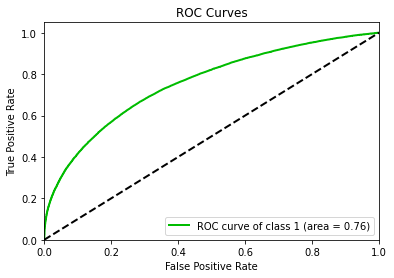

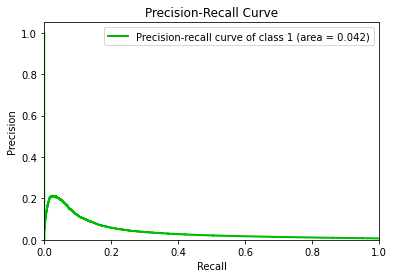

In [25]:
performances(classifier1, X_test, y_test,scale=True)

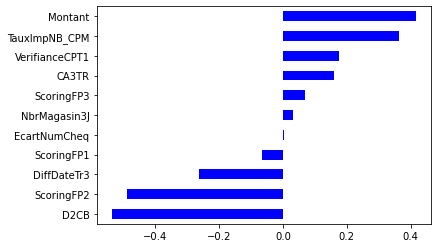

In [26]:
importances = pd.Series(model1.coef_[0], index = X_test.columns)
sorted_importances = importances.sort_values()
sorted_importances.plot(kind='barh', color='blue')
plt.show()

In [27]:
#importances = pd.Series(clf1.feature_importances_, index = XTest.columns)
#sorted_importances = importances.sort_values()
#sorted_importances.plot(kind='barh', color='lightgreen')
#plt.show()

In [28]:
# Define the Logistic Regression model with weights
model2 = LogisticRegression(random_state=0, penalty='elasticnet', l1_ratio=0.5, solver='saga', C=0.01, max_iter=100)

In [29]:
resampling1 = SMOTE(random_state=0)
# Define the pipeline, tell it to combine SMOTE with the Logistic Regression model
clf2 = Pipeline([('SMOTE', resampling1), ('Logistic Regression', model2)])

# Fit your pipeline onto your training set and obtain predictions by fitting the model onto the test data 
classifier2=delayed(clf2.fit)(X_train_scale, y_train).compute() 

-------------------------------------------------------
Modèle :
 Pipeline(steps=[('SMOTE', SMOTE(random_state=0)),
                ('Logistic Regression',
                 LogisticRegression(C=0.01, l1_ratio=0.5, penalty='elasticnet',
                                    random_state=0, solver='saga'))])
-------------------------------------------------------
F1_score :
 0.029949943084084746
-------------------------------------------------------
Estimateurs :
               precision    recall  f1-score   support

           0       1.00      0.73      0.84   4616777
           1       0.02      0.65      0.03     29995

    accuracy                           0.73   4646772
   macro avg       0.51      0.69      0.44   4646772
weighted avg       0.99      0.73      0.84   4646772

-------------------------------------------------------
Matrice de confusion :
 [[3360021 1256756]
 [  10433   19562]]
-------------------------------------------------------
Auc Score :
 0.6899801759794375


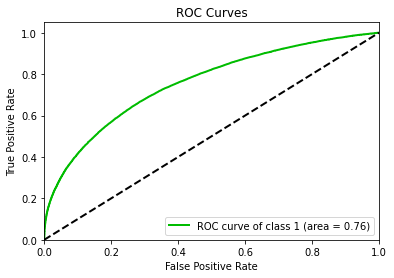

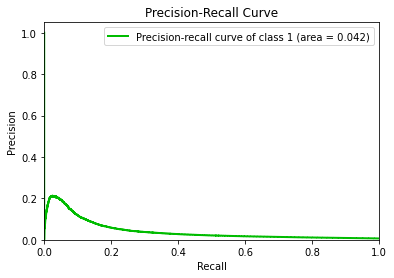

In [30]:
performances(classifier2, X_test, y_test,scale=True)

**Modifier le seuil d'affectation**

In [32]:
from numpy import arange
from numpy import argmax

In [33]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')

In [34]:
def modif_seuil(classifier,X_test_scale,y_test):
    # predict probabilities
    yhat = delayed(classifier.predict_proba)(X_test_scale).compute()
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0.1, 1, 0.1)
    # evaluate each threshold
    scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    s=('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))
    return s

In [35]:
sol1=modif_seuil(classifier1,X_test_scale,y_test)
sol1

'Threshold=0.900, F-Score=0.10881'

In [36]:
sol2=modif_seuil(classifier2,X_test_scale,y_test)
sol2

'Threshold=0.900, F-Score=0.10883'

## 2. Auto_encoder - outlier detection

In [37]:
# Importation de l'algorithme AutoEncoder du module pyOD
from pyod.models.auto_encoder import AutoEncoder

In [38]:
# Entraînement sur les données train avec une contamination de 0.1
auto_name = 'AutoEncoder'
auto = AutoEncoder(epochs=5, 
                   contamination=0.1, 
                   hidden_neurons =[14, 2, 2, 14], 
                   batch_size = 1024)
auto.fit(X_train_scale)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dropout (Dropout)           (None, 11)                0         
                                                                 
 dense_1 (Dense)             (None, 11)                132       
                                                                 
 dropout_1 (Dropout)         (None, 11)                0         
                                                                 
 dense_2 (Dense)             (None, 14)                168       
                                                                 
 dropout_2 (Dropout)         (None, 14)                0         
                                                                 
 dense_3 (Dense)             (None, 2)                 3

AutoEncoder(batch_size=1024, contamination=0.1, dropout_rate=0.2, epochs=5,
      hidden_activation='relu', hidden_neurons=[14, 2, 2, 14],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x00000174A8AC9D30>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=None, validation_size=0.1, verbose=1)

In [39]:
# Classes affectées aux individus de par le modèle
y_label_ae = auto.labels_
y_label_ae

array([0, 1, 0, ..., 0, 0, 0])

In [40]:
# Prédiction
y_test_pred = auto.predict(X_test_scale)
y_test_pred

145212/145212 [==============================] - 132s 897us/step


array([0, 1, 0, ..., 0, 0, 0])

In [41]:
#y_test = y_test.replace({-1: 1, 1 : 0})

In [42]:
# Matrice de confusion
cm_ae = confusion_matrix(y_test, y_test_pred)
print(cm_ae)

# Rapport de classification
cf_ae = classification_report(y_test, y_test_pred,zero_division=0)
print(cf_ae)

[[4159632  457145]
 [  22462    7533]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.95   4616777
           1       0.02      0.25      0.03     29995

    accuracy                           0.90   4646772
   macro avg       0.51      0.58      0.49   4646772
weighted avg       0.99      0.90      0.94   4646772



In [43]:
# Entraînement sur les données train
auto_name = 'AutoEncoder'
auto = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[13, 6, 6, 13],
                   hidden_activation = 'softmax',
                   batch_size = 1024,
                   dropout_rate = 0.5,
                   random_state = 2,
                   l2_regularizer = 0.9,
                   loss = 'BinaryCrossentropy',
                   preprocessing = False)

auto.fit(X_train_scale)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 11)                132       
                                                                 
 dropout_6 (Dropout)         (None, 11)                0         
                                                                 
 dense_8 (Dense)             (None, 11)                132       
                                                                 
 dropout_7 (Dropout)         (None, 11)                0         
                                                                 
 dense_9 (Dense)             (None, 13)                156       
                                                                 
 dropout_8 (Dropout)         (None, 13)                0         
                                                                 
 dense_10 (Dense)            (None, 6)                

AutoEncoder(batch_size=1024, contamination=0.0065, dropout_rate=0.5,
      epochs=15, hidden_activation='softmax',
      hidden_neurons=[13, 6, 6, 13], l2_regularizer=0.9,
      loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [44]:
# Prédiction
y_test_pred = auto.predict(X_test_scale)

# Matrice de confusion
cm_ae = confusion_matrix(y_test, y_test_pred)
print(cm_ae)

# Rapport de classification
cf_ae = classification_report(y_test, y_test_pred,zero_division=0)
print(cf_ae)

145212/145212 [==============================] - 135s 930us/step
[[4588210   28567]
 [  28357    1638]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   4616777
           1       0.05      0.05      0.05     29995

    accuracy                           0.99   4646772
   macro avg       0.52      0.52      0.52   4646772
weighted avg       0.99      0.99      0.99   4646772



In [45]:
# Entraînement sur les données train
auto_name = 'AutoEncoder'
auto_outl = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[8, 4, 2, 2, 4, 8],
                   hidden_activation = 'sigmoid',
                   batch_size = 768,
                   dropout_rate = 0.4,
                   random_state = 2,
                   l2_regularizer = 0.4,
                   loss = 'BinaryCrossentropy',
                   output_activation = 'sigmoid',
                   preprocessing = False)

auto_outl.fit(X_train_scale)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 11)                132       
                                                                 
 dropout_12 (Dropout)        (None, 11)                0         
                                                                 
 dense_15 (Dense)            (None, 11)                132       
                                                                 
 dropout_13 (Dropout)        (None, 11)                0         
                                                                 
 dense_16 (Dense)            (None, 8)                 96        
                                                                 
 dropout_14 (Dropout)        (None, 8)                 0         
                                                                 
 dense_17 (Dense)            (None, 4)                

AutoEncoder(batch_size=768, contamination=0.0065, dropout_rate=0.4, epochs=15,
      hidden_activation='sigmoid', hidden_neurons=[8, 4, 2, 2, 4, 8],
      l2_regularizer=0.4, loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [46]:
# Prédiction
y_test_pred = auto_outl.predict(X_test_scale)

# Matrice de confusion
cm_ae = confusion_matrix(y_test, y_test_pred)
print(cm_ae)

# Rapport de classification
cf_ae = classification_report(y_test, y_test_pred,zero_division=0)
print(cf_ae)

145212/145212 [==============================] - 132s 912us/step
[[4588210   28567]
 [  28357    1638]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   4616777
           1       0.05      0.05      0.05     29995

    accuracy                           0.99   4646772
   macro avg       0.52      0.52      0.52   4646772
weighted avg       0.99      0.99      0.99   4646772



Les résultats sont catastrophiques !

**Novelty detection**

Comme pour One Class SVM, on entraîne uniquement sur la classe non frauduleuse et on prédit sur les deux.

In [47]:
#sélection de la classe 0 (classe non frauduleuse)
df_train0=df_train[df_train['FlagImpaye'] == 0]
df_test0=df_test[df_test['FlagImpaye'] == 0]

In [48]:
# Définir les variables explicatives 
X_train0 = df_train0.drop(["FlagImpaye"], axis = "columns")
X_test0 = df_test0.drop(["FlagImpaye"], axis = "columns")

In [49]:
# Centrer-réduire les dataframe d'apprentissage
X_train0_scale = scaler.fit_transform(X_train0)
X_test0_scale = scaler.fit_transform(X_test0)

In [50]:
# Entraînement sur les données train 
auto_name = 'AutoEncoder'
auto_nov = AutoEncoder(epochs=15, 
                   contamination=0.0065, 
                   hidden_neurons =[8, 4, 2, 2, 4, 8],
                   hidden_activation = 'sigmoid',
                   batch_size = 768,
                   dropout_rate = 0.4,
                   random_state = 2,
                   l2_regularizer = 0.2,
                   loss = 'BinaryCrossentropy',
                   output_activation = 'sigmoid',
                   preprocessing = False)

auto_nov.fit(X_train0_scale)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 11)                132       
                                                                 
 dropout_20 (Dropout)        (None, 11)                0         
                                                                 
 dense_24 (Dense)            (None, 11)                132       
                                                                 
 dropout_21 (Dropout)        (None, 11)                0         
                                                                 
 dense_25 (Dense)            (None, 8)                 96        
                                                                 
 dropout_22 (Dropout)        (None, 8)                 0         
                                                                 
 dense_26 (Dense)            (None, 4)                

AutoEncoder(batch_size=768, contamination=0.0065, dropout_rate=0.4, epochs=15,
      hidden_activation='sigmoid', hidden_neurons=[8, 4, 2, 2, 4, 8],
      l2_regularizer=0.2, loss='BinaryCrossentropy', optimizer='adam',
      output_activation='sigmoid', preprocessing=False, random_state=2,
      validation_size=0.1, verbose=1)

In [51]:
# Prédiction
y_test_pred_nov = auto_nov.predict(X_test_scale)

# Matrice de confusion
cm_ae = confusion_matrix(y_test, y_test_pred_nov)
print(cm_ae)

# Rapport de classification
cf_ae = classification_report(y_test, y_test_pred_nov,zero_division=0)
print(cf_ae)

145212/145212 [==============================] - 154s 1ms/step
[[4587428   29349]
 [  28318    1677]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99   4616777
           1       0.05      0.06      0.05     29995

    accuracy                           0.99   4646772
   macro avg       0.52      0.52      0.52   4646772
weighted avg       0.99      0.99      0.99   4646772



En mode semi-supervisé (novelty detection), le modèle est nettement plus performant sur les bonnes prédictions, ce qui augmente le rappel. Il pêche cependant sur les faux positifs. De manière semblable à l'isolation forest, ici les caractéristiques de certaines transactions se ressemblent, la probabilité qu'elles sont dans la même classe augmente donc également.
Si les bonnes prédictions sont meilleures qu'en non supervisé, les faux positifs sont bien trop importants. Cela se répercute sur la f1-score de la classe fraduleuse.